In [189]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

# Read, Convert

In [190]:
src_folder_path = ".\\data"
df = pd.read_csv(src_folder_path + "\\20220421-a5ad2ede1017aadb3dd3df128cd0b0b5.csv", sep=";")

In [191]:
print(df.dtypes)

startDate           object
endDate             object
acc-accuracy         int64
acc-x-m/s^2         object
acc-y-m/s^2         object
                    ...   
ori-angle-z-max    float64
ori-angle-z-var    float64
ori-angle-z-std    float64
activity            object
device-id           object
Length: 61, dtype: object


In [192]:
arrayFeatures = [
    "acc-x-m/s^2",
    "acc-y-m/s^2",
    "acc-z-m/s^2",
    "gyr-x-rad/s",
    "gyr-y-rad/s",
    "gyr-z-rad/s",
    "ori-angle-x-rad",
    "ori-angle-y-rad",
    "ori-angle-z-rad"
];

def array_from_string(x):
    if isinstance(x, str):
        x = x[1:] # remove first char "["
        x = x[:-1] # remove last char "]"
        return np.fromstring(x, sep=",")
    else:
        return x

# convert arrays
for curFeature in arrayFeatures:
    df[curFeature] = df[curFeature].apply(array_from_string)
    
del arrayFeatures

In [193]:
# convert dates
df['startDate'] = df['startDate'].apply(lambda date: pd.Timestamp(date))
df['endDate'] = df['endDate'].apply(lambda date: pd.Timestamp(date))

In [194]:
STAYING = 10
JUMP_LEFT = 11
JUMP_RIGHT = 12
OTHER = 20
FAKE_JUMP_LEFT = 30
FAKE_JUMP_RIGHT = 31

LABEL_COL = 'activity-code'

def encode_label(value):
    if value == 'staying': return STAYING
    if value == 'jump_left': return JUMP_LEFT
    if value == 'jump_right': return JUMP_RIGHT
    if value == 'other': return OTHER
    if value == 'fake_jump_left': return FAKE_JUMP_LEFT
    if value == 'fake_jump_right': return FAKE_JUMP_RIGHT

# convert label
df[LABEL_COL] = df['activity'].apply(encode_label)

# Explore

In [195]:
df.columns

Index(['startDate', 'endDate', 'acc-accuracy', 'acc-x-m/s^2', 'acc-y-m/s^2',
       'acc-z-m/s^2', 'acc-x-min', 'acc-x-mean', 'acc-x-max', 'acc-x-var',
       'acc-x-std', 'acc-y-min', 'acc-y-mean', 'acc-y-max', 'acc-y-var',
       'acc-y-std', 'acc-z-min', 'acc-z-mean', 'acc-z-max', 'acc-z-var',
       'acc-z-std', 'gyr-accuracy', 'gyr-x-rad/s', 'gyr-y-rad/s',
       'gyr-z-rad/s', 'gyr-x-min', 'gyr-x-mean', 'gyr-x-max', 'gyr-x-var',
       'gyr-x-std', 'gyr-y-min', 'gyr-y-mean', 'gyr-y-max', 'gyr-y-var',
       'gyr-y-std', 'gyr-z-min', 'gyr-z-mean', 'gyr-z-max', 'gyr-z-var',
       'gyr-z-std', 'mag-accuracy', 'ori-angle-x-rad', 'ori-angle-y-rad',
       'ori-angle-z-rad', 'ori-angle-x-min', 'ori-angle-x-mean',
       'ori-angle-x-max', 'ori-angle-x-var', 'ori-angle-x-std',
       'ori-angle-y-min', 'ori-angle-y-mean', 'ori-angle-y-max',
       'ori-angle-y-var', 'ori-angle-y-std', 'ori-angle-z-min',
       'ori-angle-z-mean', 'ori-angle-z-max', 'ori-angle-z-var',
       'ori-angle-

In [196]:
df.head(3)

,startDate,endDate,acc-accuracy,acc-x-m/s^2,acc-y-m/s^2,acc-z-m/s^2,acc-x-min,acc-x-mean,acc-x-max,acc-x-var,...,ori-angle-y-var,ori-angle-y-std,ori-angle-z-min,ori-angle-z-mean,ori-angle-z-max,ori-angle-z-var,ori-angle-z-std,activity,device-id,activity-code
0,2022-04-20 23:30:22.835000+00:00,2022-04-20 23:30:24.111000+00:00,2,"[0.04962164, 0.04962164, 0.04962164, 0.0496216...","[0.2781539, -0.2528081, -0.2528081, -0.2528081...","[-0.35332966, -0.9656162, -0.9656162, -0.96561...",-3.097097,0.051071,2.626643,1.009453,...,0.010166,0.100828,0.092167,0.267150,0.538387,0.014938,0.122220,jump_left,a5ad2ede1017aadb3dd3df128cd0b0b5,11
1,2022-04-20 23:30:29.997000+00:00,2022-04-20 23:30:31.271000+00:00,2,"[-0.08512929, -0.08512929, -0.08512929, -0.085...","[0.17111015, 0.17111015, 0.17111015, 0.1711101...","[-0.31947136, -0.31947136, -0.31947136, -0.319...",-3.812625,-0.221583,2.575436,1.578221,...,0.015123,0.122976,0.007846,0.263486,0.916610,0.062400,0.249799,jump_right,a5ad2ede1017aadb3dd3df128cd0b0b5,12
2,2022-04-20 23:30:39.887000+00:00,2022-04-20 23:30:40.513000+00:00,2,"[-0.67601275, -1.9999166, -1.4998112, 0.876384...","[-2.5262933, -1.9065523, -1.9065523, -1.406114...","[-3.6014862, -2.072174, -2.5946655, -4.345276,...",-3.812625,-0.189698,2.575436,1.432908,...,0.019756,0.140555,0.054403,0.261767,0.916610,0.059338,0.243594,staying,a5ad2ede1017aadb3dd3df128cd0b0b5,10


In [197]:
arraySizes = df['acc-x-m/s^2'].apply(lambda array: len(array))
arraySizes = list(set(arraySizes))
print("Raw array sizes: " + str(arraySizes))

Raw array sizes: [64]


In [198]:
def plot_data(dataArray, title):
    pltIndex = 131
    plt.figure(figsize=(14, 2))

    for curPlt in dataArray:
        plt.subplot(pltIndex)
        plt.plot(curPlt['data'])
        plt.ylabel(curPlt['name'])
        plt.grid(True)
        
        pltIndex += 1;

    plt.subplots_adjust(hspace=0.25, wspace=0.35)

    plt.suptitle(title)
    plt.show()

def plot_data_from_row(dataFrame, rowIndex, colNames, colLabel):
    pltData = []
    pltLabel = dataFrame.at[rowIndex, colLabel];
    
    for colName in colNames:
        pltData.append({ 'data': dataFrame.at[rowIndex, colName], 'name': colName })

    plot_data(pltData, pltLabel)

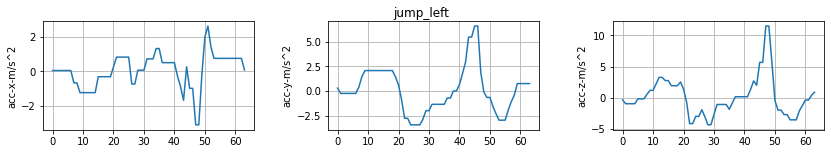

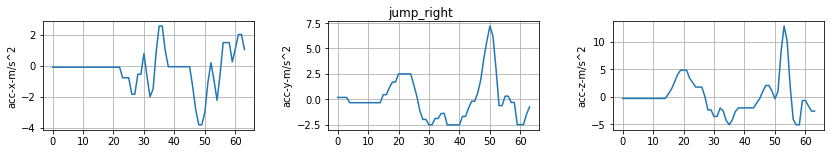

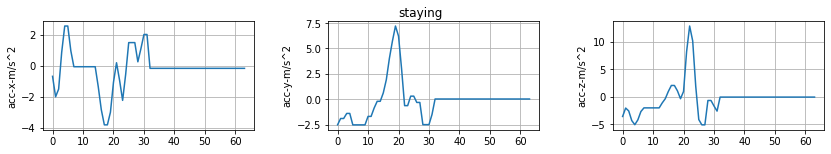

In [199]:
plot_data_from_row(df, 0, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], 'activity')
plot_data_from_row(df, 1, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], 'activity')
plot_data_from_row(df, 2, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], 'activity')

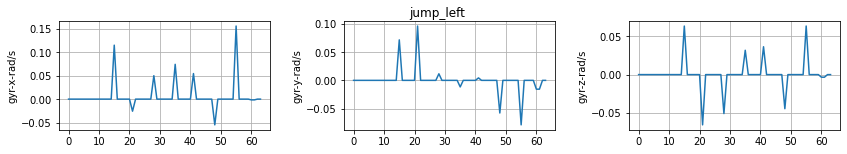

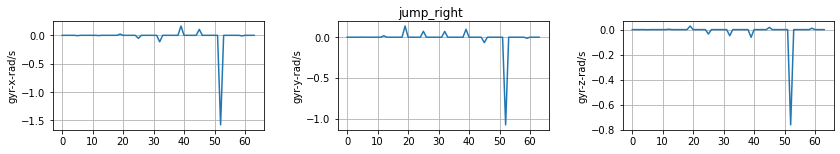

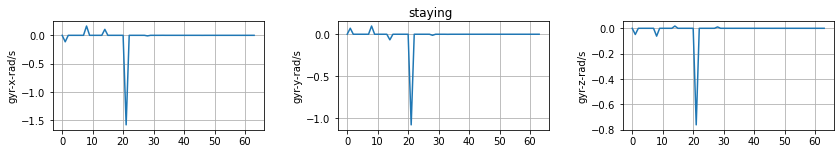

In [200]:
plot_data_from_row(df, 0, ['gyr-x-rad/s', 'gyr-y-rad/s', 'gyr-z-rad/s'], 'activity')
plot_data_from_row(df, 1, ['gyr-x-rad/s', 'gyr-y-rad/s', 'gyr-z-rad/s'], 'activity')
plot_data_from_row(df, 2, ['gyr-x-rad/s', 'gyr-y-rad/s', 'gyr-z-rad/s'], 'activity')

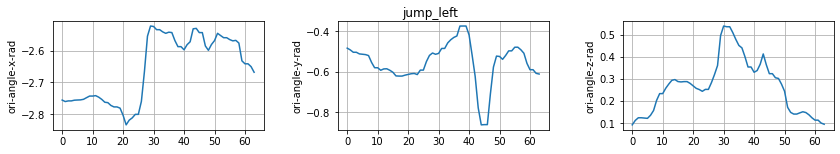

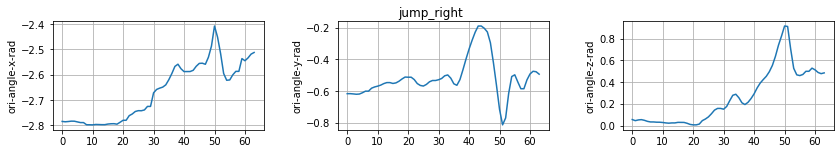

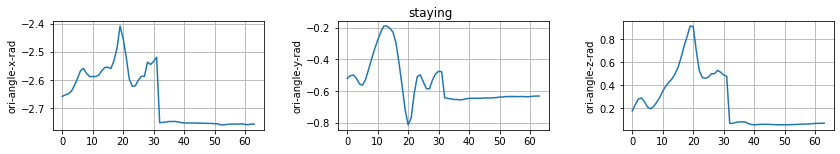

In [201]:
plot_data_from_row(df, 0, ['ori-angle-x-rad', 'ori-angle-y-rad', 'ori-angle-z-rad'], 'activity')
plot_data_from_row(df, 1, ['ori-angle-x-rad', 'ori-angle-y-rad', 'ori-angle-z-rad'], 'activity')
plot_data_from_row(df, 2, ['ori-angle-x-rad', 'ori-angle-y-rad', 'ori-angle-z-rad'], 'activity')

# Clean

In [202]:
# remove date cols
df.drop('startDate', inplace=True, axis=1)
df.drop('endDate', inplace=True, axis=1)

# remove sensor accuracy cols
df.drop('acc-accuracy', inplace=True, axis=1)
df.drop('gyr-accuracy', inplace=True, axis=1)
df.drop('mag-accuracy', inplace=True, axis=1)

# remove device-id col
df.drop('device-id', inplace=True, axis=1)

# Enrichment

In [203]:
# root mean square = sqrt(x^2 + y^2 + z^2)
def rms(xArray, yArray, zArray):
    rms_array = np.square([xArray, yArray, zArray])
    rms_array = np.sum(rms_array, axis=0)
    rms_array = np.sqrt(rms_array)
    return rms_array

# signal magnitude area = sum(abs(x) + abs(y) + abs(z)) / arraySize
def sma(xArray, yArray, zArray):
    arraySize = len(xArray)
    result = np.abs([xArray, yArray, zArray])
    result = np.sum(result)
    return result / arraySize

# pearson correlation coefficient = cov(A, B) / (std(A) * std(B))
def pcorr(arrayA, arrayB):
    corr_matrix = np.corrcoef(arrayA, arrayB)
    corr = corr_matrix[0][1]
    
    if np.isnan(corr):
        return 0
    else:
        return corr
    
# difference between max and min positions
def min_max_diff(array):
    maxIndex = np.argmax(array, axis=0)
    minIndex = np.argmin(array, axis=0)
    return maxIndex - minIndex

# average of array part
def mean_of_part(array, fromIndex, toIndex):
    array = array[fromIndex:toIndex]
    return np.mean(array)

# average peak-trough distance
def aptd(array):
    peakValue = array[0]
    troughValue = array[0]
    prevSlope = 0
    curSlope = 0
    sum = 0
    arraySize = len(array)
    evaluateSize = arraySize + 1
    
    for i in range(evaluateSize):
        if i == 0:
            curValue = array[i]
            continue
        
        prevValue = curValue
        prevSlope = curSlope
        
        if i < arraySize:
            curValue = array[i]
            curSlope = curValue - prevValue
        else:
            curSlope = prevSlope * -1
        
        # peak found
        if prevSlope > 0 and curSlope <= 0:
            peakValue = prevValue
            sum += peakValue - troughValue
            #print(f'=== peak found ({troughValue} to {peakValue})')
        # trough found
        elif prevSlope < 0 and curSlope >= 0:
            troughValue = prevValue
            sum += troughValue - peakValue
            #print(f'=== trough found ({peakValue} to {troughValue})')
            
    return sum / arraySize

In [204]:
newFeatures = [
    # accelerometer
    {
        'name': 'acc-rms', 'dtype': object,
        'func': (lambda row: rms(row["acc-x-m/s^2"], row["acc-y-m/s^2"], row["acc-z-m/s^2"]))
    },
    { 
        'name': 'acc-sma', 'dtype': np.float64,
        'func': (lambda row: sma(row["acc-x-m/s^2"], row["acc-y-m/s^2"], row["acc-z-m/s^2"]))
    },
    { 
        'name': 'acc-pcorr-xy', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["acc-x-m/s^2"], row["acc-y-m/s^2"]))
    },
    { 
        'name': 'acc-pcorr-xz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["acc-x-m/s^2"], row["acc-z-m/s^2"]))
    },
    { 
        'name': 'acc-pcorr-yz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["acc-y-m/s^2"], row["acc-z-m/s^2"]))
    },
    {
        'name': 'acc-x-min-max-diff', 'dtype': np.float64,
        'func': (lambda row: min_max_diff(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-x-mean-1prt', 'dtype': np.float64,
        'func': (lambda row: mean_of_part(row["acc-x-m/s^2"], 0, 16))
    },
    {
        'name': 'acc-x-mean-2prt', 'dtype': np.float64,
        'func': (lambda row: mean_of_part(row["acc-x-m/s^2"], 16, 32))
    },
    {
        'name': 'acc-x-mean-3prt', 'dtype': np.float64,
        'func': (lambda row: mean_of_part(row["acc-x-m/s^2"], 32, 48))
    },
    {
        'name': 'acc-x-mean-4prt', 'dtype': np.float64,
        'func': (lambda row: mean_of_part(row["acc-x-m/s^2"], 32, 64))
    },
    {
        'name': 'acc-x-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-y-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["acc-y-m/s^2"]))
    },
    {
        'name': 'acc-z-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["acc-z-m/s^2"]))
    },
    # gyroscope
    {
        'name': 'gyr-rms', 'dtype': object,
        'func': (lambda row: rms(row["gyr-x-rad/s"], row["gyr-y-rad/s"], row["gyr-z-rad/s"]))
    },
    { 
        'name': 'gyr-sma', 'dtype': np.float64,
        'func': (lambda row: sma(row["gyr-x-rad/s"], row["gyr-y-rad/s"], row["gyr-z-rad/s"]))
    },
    { 
        'name': 'gyr-pcorr-xy', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["gyr-x-rad/s"], row["gyr-y-rad/s"]))
    },
    { 
        'name': 'gyr-pcorr-xz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["gyr-x-rad/s"], row["gyr-z-rad/s"]))
    },
    { 
        'name': 'gyr-pcorr-yz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["gyr-y-rad/s"], row["gyr-z-rad/s"]))
    },
    {
        'name': 'gyr-x-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["gyr-x-rad/s"]))
    },
    {
        'name': 'gyr-y-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["gyr-y-rad/s"]))
    },
    {
        'name': 'gyr-z-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["gyr-z-rad/s"]))
    },
    # magnetometer
    {
        'name': 'mag-rms', 'dtype': object,
        'func': (lambda row: rms(row["ori-angle-x-rad"], row["ori-angle-y-rad"], row["ori-angle-z-rad"]))
    },
    { 
        'name': 'mag-sma', 'dtype': np.float64,
        'func': (lambda row: sma(row["ori-angle-x-rad"], row["ori-angle-y-rad"], row["ori-angle-z-rad"]))
    },
    { 
        'name': 'mag-pcorr-xy', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["ori-angle-x-rad"], row["ori-angle-y-rad"]))
    },
    { 
        'name': 'mag-pcorr-xz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["ori-angle-x-rad"], row["ori-angle-z-rad"]))
    },
    { 
        'name': 'mag-pcorr-yz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["ori-angle-y-rad"], row["ori-angle-z-rad"]))
    },
    # activity label
    {
        'name': 'lateral-move', 'dtype': np.float64,
        'func': (lambda row: int(row[LABEL_COL] == JUMP_LEFT or row[LABEL_COL] == JUMP_RIGHT))
    },
    {
        'name': 'fake-move', 'dtype': np.float64,
        'func': (lambda row: int(row[LABEL_COL] == FAKE_JUMP_LEFT or row[LABEL_COL] == FAKE_JUMP_RIGHT))
    },
    {
        'name': 'jump-left', 'dtype': np.float64,
        'func': (lambda row: int(row[LABEL_COL] == JUMP_LEFT))
    },
    {
        'name': 'jump-right', 'dtype': np.float64,
        'func': (lambda row: int(row[LABEL_COL] == JUMP_RIGHT))
    },
    {
        'name': 'staying', 'dtype': np.float64,
        'func': (lambda row: int(row[LABEL_COL] != JUMP_LEFT and row[LABEL_COL] != JUMP_RIGHT))
    },
    
    #TODO add entropy and energy
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html
]

print("added new features")

# add new features
for newFeature in newFeatures:
    # add new column
    df[newFeature['name']] = pd.Series(df[LABEL_COL].apply(lambda x: 0), dtype=newFeature['dtype'])

    # fill new column
    for rowIndex, row in df.iterrows():
        df.at[rowIndex, newFeature['name']] = newFeature['func'](row);
        
        if (rowIndex == 0):
            print(newFeature['name'] + ": " + str(df.at[rowIndex, newFeature['name']]))

added new features
acc-rms: [ 0.45240883  0.99939426  0.99939426  0.99939426  0.99939426  0.31950775
  0.31950775  0.80102453  1.69392604  2.67384755  2.67384755  3.26337035
  4.04976048  4.04976048  3.64853477  3.44849511  2.83372395  2.83372395
  2.83372395  2.91517894  1.53021918  1.3971815   5.06688668  5.06688668
  4.63949967  4.63949967  4.01324607  4.65479463  5.22124277  4.76940971
  3.33726441  1.88680668  1.88680668  1.88680668  2.18701602  2.65591135
  1.24091182  0.89912205  0.52858967  0.52858967  0.81745668  1.78381716
  3.31109086  6.31031135  5.81543856  8.73673688  8.73673688 12.07002408
 11.92231991  5.72584734  2.14570398  3.65742497  3.36240132  4.08813318
  4.08813318  4.69115998  4.13276902  3.79956856  2.29000531  1.65000346
  1.12050632  1.12050632  1.11875138  1.1612659 ]
acc-sma: 4.7844445618750004
acc-pcorr-xy: -0.5233921900079217
acc-pcorr-xz: -0.7416859885092927
acc-pcorr-yz: 0.6804506145293179
acc-x-min-max-diff: 4.0
acc-x-mean-1prt: -0.54257322375
acc-x-m

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\DavidCraveiro\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


gyr-y-aptd: -6.835367656250022e-05
gyr-z-aptd: -0.0010591354843750003
mag-rms: [2.79948993 2.80633647 2.8069318  2.8069318  2.80613156 2.80583457
 2.80640309 2.80662447 2.81095104 2.81367487 2.81367487 2.81712596
 2.82223319 2.83059568 2.84123047 2.84364572 2.85594293 2.86073747
 2.86073747 2.86270932 2.88294199 2.91048379 2.89526874 2.88872021
 2.87401567 2.87401567 2.82845212 2.73468807 2.62882385 2.62118592
 2.63019815 2.63459108 2.63459108 2.63109397 2.62711666 2.61687112
 2.61499798 2.62575681 2.63787918 2.63787918 2.65119179 2.65403427
 2.67144622 2.67991846 2.69745195 2.70442192 2.70442192 2.69806688
 2.6791877  2.64735003 2.63261218 2.60720522 2.60880384 2.61062496
 2.61062496 2.61343361 2.61757497 2.61825779 2.62932716 2.69359439
 2.70893767 2.70893767 2.72104753 2.73899758]
mag-sma: 3.478760708375
mag-pcorr-xy: 0.13280839282386117
mag-pcorr-xz: 0.4273373108126142
mag-pcorr-yz: 0.04110647700908269
lateral-move: 1.0
fake-move: 0.0
jump-left: 1.0
jump-right: 0.0
staying: 0.0


# Describe

In [205]:
df.describe()

,acc-x-min,acc-x-mean,acc-x-max,acc-x-var,acc-x-std,acc-y-min,acc-y-mean,acc-y-max,acc-y-var,acc-y-std,...,gyr-z-aptd,mag-sma,mag-pcorr-xy,mag-pcorr-xz,mag-pcorr-yz,lateral-move,fake-move,jump-left,jump-right,staying
count,53.000000,53.000000,53.000000,5.300000e+01,5.300000e+01,53.000000,53.000000,53.000000,53.000000,53.000000,...,5.300000e+01,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,-1.765729,-0.059856,1.493047,6.287104e-01,7.113959e-01,-3.060402,-0.026953,3.844795,4.841062,1.632370,...,6.487621e-04,3.721331,0.195404,0.424884,0.131359,0.377358,0.226415,0.207547,0.169811,0.622642
std,1.089457,0.107450,0.831734,4.324823e-01,3.535315e-01,2.922382,0.117857,3.422236,6.803078,1.489391,...,3.040571e-03,0.365505,0.447777,0.606627,0.477868,0.489364,0.422516,0.409432,0.379060,0.489364
min,-3.812625,-0.368517,-0.364124,1.998401e-15,4.470348e-08,-11.105948,-0.298359,-0.123535,0.000000,0.000000,...,-3.586111e-03,3.323610,-0.869877,-0.905948,-0.865627,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-2.572295,-0.125453,1.022371,3.240713e-01,5.692726e-01,-3.633060,-0.098268,0.219136,0.055654,0.235911,...,-2.027457e-04,3.474571,-0.093928,0.141146,-0.197189,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.045036,-0.031453,1.600753,6.371266e-01,7.982021e-01,-2.539179,-0.034059,4.630107,3.266148,1.807249,...,1.779764e-08,3.552837,0.301050,0.666375,0.184226,0.000000,0.000000,0.000000,0.000000,1.000000
75%,-0.711987,0.013568,1.965878,9.075042e-01,9.526302e-01,-0.638483,0.014592,6.568778,5.337472,2.310297,...,4.589729e-05,4.002604,0.520662,0.878881,0.509340,1.000000,0.000000,0.000000,0.000000,1.000000
max,-0.045985,0.141092,3.178488,1.578221e+00,1.256273e+00,0.096202,0.278286,10.179729,26.315008,5.129816,...,1.242003e-02,4.541841,0.976054,0.994259,0.946588,1.000000,1.000000,1.000000,1.000000,1.000000


In [206]:
MIN_NEG_CORR = -0.5
MIN_POS_CORR = 0.5

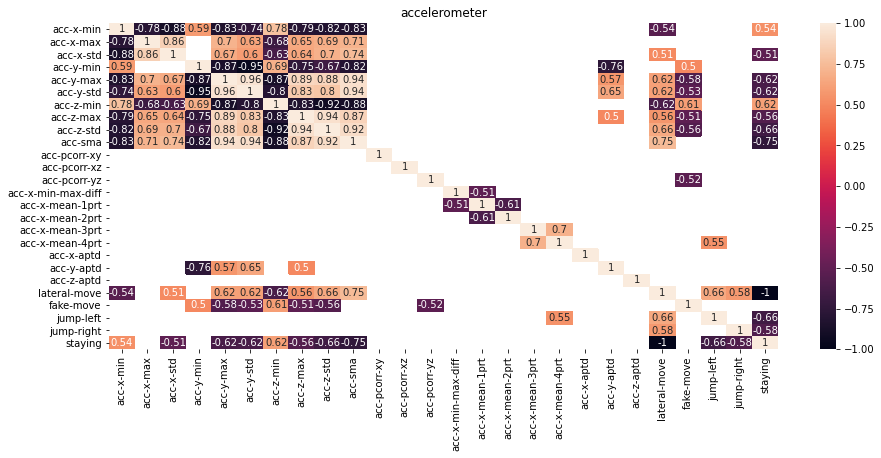

In [207]:
dfCorr = df[[
    'acc-x-min',
    #'acc-x-mean',
    'acc-x-max',
    #'acc-x-var',
    'acc-x-std',
    'acc-y-min',
    #'acc-y-mean',
    'acc-y-max',
    #'acc-y-var',
    'acc-y-std',
    'acc-z-min',
    #'acc-z-mean',
    'acc-z-max',
    #'acc-z-var',
    'acc-z-std',
    'acc-sma',
    'acc-pcorr-xy',
    'acc-pcorr-xz',
    'acc-pcorr-yz',
    'acc-x-min-max-diff',
    'acc-x-mean-1prt',
    'acc-x-mean-2prt',
    'acc-x-mean-3prt',
    'acc-x-mean-4prt',
    'acc-x-aptd',
    'acc-y-aptd',
    'acc-z-aptd',
    'lateral-move',
    'fake-move',
    'jump-left',
    'jump-right',
    'staying',
    #LABEL_COL
]].corr()

dfCorr = dfCorr[((dfCorr > MIN_POS_CORR) | (dfCorr < MIN_NEG_CORR))]

plt.figure(figsize=(15,6))
plt.title('accelerometer')
sn.heatmap(dfCorr, annot=True)
plt.show()

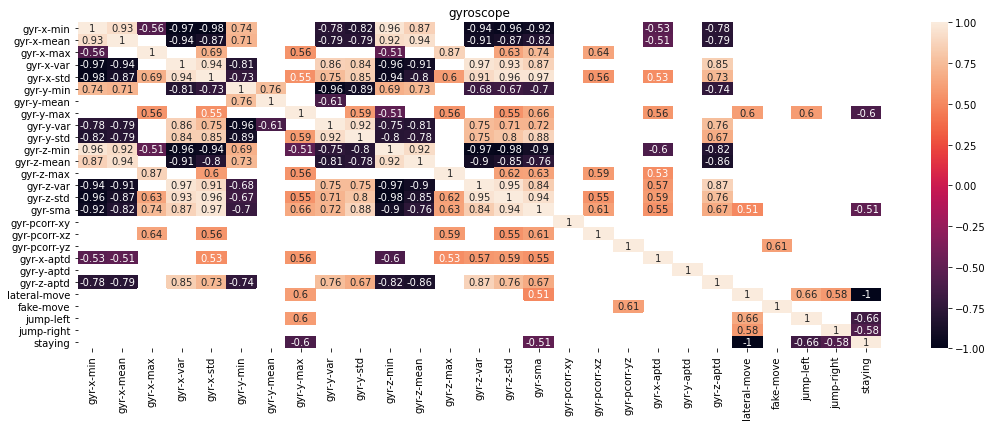

In [208]:
dfCorr = df[[
    'gyr-x-min',
    'gyr-x-mean',
    'gyr-x-max',
    'gyr-x-var',
    'gyr-x-std',
    'gyr-y-min',
    'gyr-y-mean',
    'gyr-y-max',
    'gyr-y-var',
    'gyr-y-std',
    'gyr-z-min',
    'gyr-z-mean',
    'gyr-z-max',
    'gyr-z-var',
    'gyr-z-std',
    'gyr-sma',
    'gyr-pcorr-xy',
    'gyr-pcorr-xz',
    'gyr-pcorr-yz',
    'gyr-x-aptd',
    'gyr-y-aptd',
    'gyr-z-aptd',
    'lateral-move',
    'fake-move',
    'jump-left',
    'jump-right',
    'staying',
    #LABEL_COL
]].corr()

dfCorr = dfCorr[((dfCorr > MIN_POS_CORR) | (dfCorr < MIN_NEG_CORR))]

plt.figure(figsize=(18,6))
plt.title('gyroscope')
sn.heatmap(dfCorr, annot=True)
plt.show()

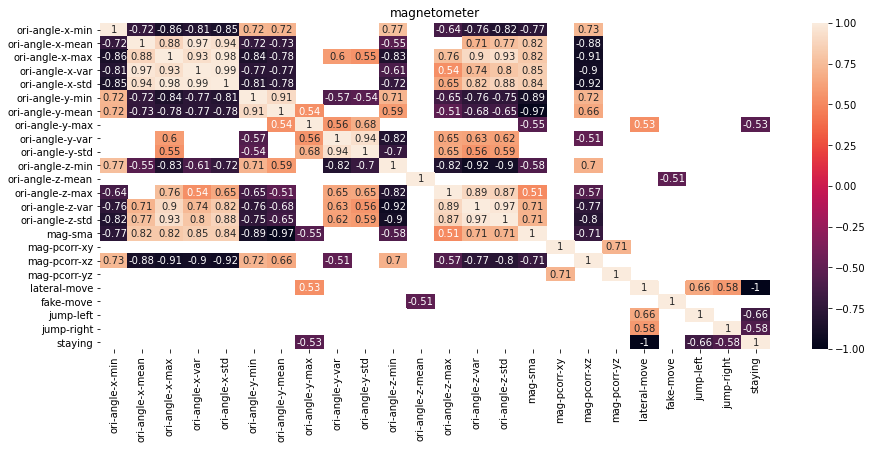

In [209]:
dfCorr = df[[
    'ori-angle-x-min',
    'ori-angle-x-mean',
    'ori-angle-x-max',
    'ori-angle-x-var',
    'ori-angle-x-std',
    'ori-angle-y-min',
    'ori-angle-y-mean',
    'ori-angle-y-max',
    'ori-angle-y-var',
    'ori-angle-y-std',
    'ori-angle-z-min',
    'ori-angle-z-mean',
    'ori-angle-z-max',
    'ori-angle-z-var',
    'ori-angle-z-std',
    'mag-sma',
    'mag-pcorr-xy',
    'mag-pcorr-xz',
    'mag-pcorr-yz',
    'lateral-move',
    'fake-move',
    'jump-left',
    'jump-right',
    'staying',
    #LABEL_COL
]].corr()

dfCorr = dfCorr[((dfCorr > MIN_POS_CORR) | (dfCorr < MIN_NEG_CORR))]

plt.figure(figsize=(15,6))
plt.title('magnetometer')
sn.heatmap(dfCorr, annot=True)
plt.show()